In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


2025-06-14 17:08:22.623217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749888502.635477   33688 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749888502.639366   33688 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749888502.648799   33688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749888502.648811   33688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749888502.648812   33688 computation_placer.cc:177] computation placer alr

In [14]:
import os
data_dir = "temp/tfds"
cwd = os.getcwd()
new_folder = os.path.join(cwd, data_dir)  # Define full path

os.makedirs(new_folder, exist_ok=True)  # Create the folder if it doesn't exist

print(f"Created: {new_folder}")


Created: /home/cillian-hayde/Documents/PythonProjects/jax/temp/tfds


In [15]:
data, info = tfds.load(name="mnist",
                        data_dir=data_dir,
                        as_supervised=True,
                        with_info=True)


data_train = data['train']
data_test = data['test']
 

/home/cillian-hayde/Documents/PythonProjects/jax/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  75%|███████▌  | 3/4 [00:01<00:00,  2.00 url/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]I0000 00:00:1749886365.406265   29728 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4974 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
                                                                        

Dataset mnist downloaded and prepared to temp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


2025-06-14 16:40:32.760595: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-14 16:40:32.785425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-14 16:40:32.786060: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


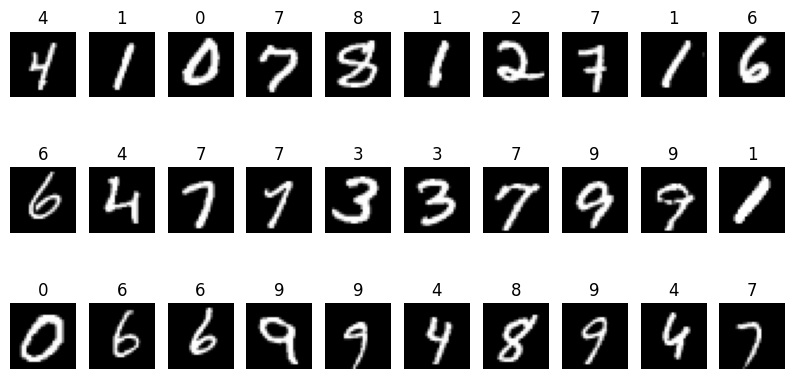

In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1
plt.show()

In [18]:
HEIGHT = 28
WIDTH = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

def preprocess(img, label):
    "Resize Image and Preprocess"
    return (tf.cast(img,tf.float32)/255.0), label

train_data = tfds.as_numpy(
    data_train.map(preprocess).batch(32).prefetch(1))
test_data = tfds.as_numpy(
    data_test.map(preprocess).batch(32).prefetch(1))


In [20]:
from jax import random
LAYER_SIZES = [28*28, 512, 10]
PARAM_SCALE = 0.01

In [21]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
    """Initialize all layers for a fully-connected
    neural network with given sizes"""
    def random_layer_params(m, n, key, scale=1e-2):
        """A helper function to randomly initialize
        weights and biases of a dense layer"""
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]